In [1]:
import os
import iris
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from matplotlib import cm
import calendar
os.chdir('/home/548/eh6215/python/BARPA_evaluation/emma/PBE')
import datasets
import datetime as dt

In [3]:
ia39path = "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/output/AUS-15/BOM/{model}/{scen}/{rev}/BOM-BARPA-R/v1/{time}/{var}/{var}_AUS-15_{model}_{scen}_r1i1p1f1_BOM-BARPA-R_v1_{time}_{year}01-{year}12.nc"

In [2]:
nrm = xr.open_dataset("/g/data/tp28/dev/eh6215/datasets/NRM_clusters.nc")
order=np.array([(nrm.lat.where(nrm.ids==i).mean().values*1) for i in range(len(nrm.labels))]).argsort()
labels = nrm.labels.values[order]
print(labels)
labels[2] = "S&SW Flatlands"

['Southern Slopes' 'Murray Basin' 'Southern and South-Western Flatlands'
 'Central Slopes' 'East Coast' 'Rangelands' 'Monsoonal North'
 'Wet Tropics']


In [5]:
nino = datasets.nino()
dmi = datasets.dmi()
dmi=dmi.rolling(3,center=True).mean()[1:-1]
dmi.index = dmi.index.to_series().apply(lambda x: dt.datetime(x.year,x.month,1))
sam = datasets.sam()

In [6]:

def open_datasets(models,var,startyear,endyear):
    out = {}
    for model in models:
        if model == 'AGCDv2':
            assert var == 'pr'
            out[model] = xr.open_mfdataset(["/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_{year}.nc".format(year=year) for year in range(startyear,endyear)])
            out[model] = out[model].rename({'precip':'pr'})
        elif model == 'AGCDv1':
            assert var in ['tasmax','tasmin','pr']
            var2,agg = {'tasmax':('tmax','mean'),'tasmin':('tmin','mean'),'pr':('precip','total')}[var]
            out[model] = xr.open_mfdataset(["/g/data/zv2/agcd/v1/{var}/{agg}/r005/01month/agcd_v1_{var}_{agg}_r005_monthly_{year}.nc".format(var=var2,agg=agg,year=year) for year in range(startyear,endyear)])
            out[model] = out[model].rename({var2:var})
        else:
            assert model in ['BARPA_ERA5','BARPA_ACCESS-CM2','BARPA_ACCESS-ESM1-5']
            if model =='BARPA_ERA5':
                scenario = 'evaluation'
            else:
                scenario = 'historical'
            centre, rev = {"BARPA_ACCESS-CM2":("CSIRO-BOM","r4i1p1f1"),"BARPA_ACCESS-ESM1-5":('CSIRO-BOM','r6i1p1f1','gn','latest'),"BARPA_ERA5":('ECMWF','r1i1p1f1')}[model]
            out[model] =  xr.open_mfdataset([ia39path.format(model=centre+"-"+model.split("_")[1], scen=scenario, rev = rev, time='mon', var=var, year = year) for year in range(startyear,endyear)])
    return out

In [7]:
def agg_regions(data,nrm,var,order):
    # regrid regions to data grid
    regridder = xe.Regridder(nrm, data, 'nearest_s2d')
    nrm_regrid = regridder(nrm.ids)
    regions = xr.concat(
                        [(nrm_regrid == region_id).expand_dims(region=[i])
                         for i, region_id in enumerate(order)], 
                          dim='region'
                       )
    result = data[var].where(regions).mean(['lat', 'lon'])
    result = result.load()  # now the data is small (8 timeseries), commit to ne
    return result


In [9]:
def annotate(pcolormesh,data,string):
    amp = (np.array(cm.get_cmap(x.cmap)(x.norm(data)))**2).mean(axis=2)
    print(amp.shape,data.shape)
    for i in range(data.shape[1]):
        for j in range(data.shape[0]):
            plt.text(i,j,string%data[j,i],color=['k','w'][int(amp[j,i]<0.4)],ha='center',va='center')
    cm.get_cmap('BrBG')(1)

In [85]:
def make_composites(data,indices):
    array = []
    labels = []
    i = 0
    for index in indices:
        for model in data:
            subset=data[model][[(indices[index][dt.datetime(year,month,1)]  if dt.datetime(year,month,1) in indices[index].index else False) \
                 for (year,month) in zip(data[model]['time.year'].values,data[model]['time.month'].values)]]
            array.append(subset.mean('time').expand_dims(index=[i]))
            labels.append(model+" "+index)
            i+=1
    return xr.concat(array,dim='index'),labels
    

In [64]:
var='pr'
pr = open_datasets(['BARPA_ERA5','AGCDv2'],var,1979,2008)
month_length = pr['BARPA_ERA5'].time.dt.days_in_month
pr['BARPA_ERA5'][var] = pr['BARPA_ERA5'][var]*86400*month_length
agg_pr = {}
for model in pr:
    agg_pr[model] = agg_regions(pr[model],nrm,var,order)
    agg_pr[model] = agg_pr[model]/agg_pr[model].mean('time')
    agg_pr[model] = agg_pr[model].groupby("time.month") - agg_pr[model].groupby("time.month").mean("time")  

    

In [86]:
pr_nino,indices_nino = make_composites(agg_pr, {"La Niña":(nino<-0.8),"El Niño":(nino>0.8)})
pr_iod,indices_iod = make_composites(agg_pr, {"Negative IOD":(dmi<-0.4),"Positive IOD":(dmi>0.4)})

In [25]:
summer,winter = {},{}
is_summer = lambda x: (x >= 11) | (x <=3)
is_winter = lambda x: (x >= 5) & (x <=9)
for model in pr:
    summer[model] = agg_pr[model].sel(time=is_summer(agg_pr[model]['time.month']))
    winter[model] = agg_pr[model].sel(time=is_winter(agg_pr[model]['time.month']))
    
pr_sam_summer,indices_sam = make_composites(summer, {"Negative SAM":(sam<-1),"Positive SAM":(sam>1)})
pr_sam_winter,indices_sam = make_composites(winter, {"Negative SAM":(sam<-1),"Positive SAM":(sam>1)})
 

In [76]:
pr_nino*100


<xarray.DataArray 'pr' (index: 4, region: 8)>
array([[  5.31139159,  15.33145652,  18.1477455 ,  14.48713713,
         22.18846905,  30.49835717,  18.77140397,  15.44922729],
       [  1.62973572,  15.64000398,  15.64509124,  10.77312753,
         21.34636045,  22.43106812,  13.23769242,  23.53753299],
       [ -7.92193038, -15.9611624 ,   2.63833571,  -3.18893697,
         -9.24684506,   0.7509967 ,   4.05514747, -11.97154777],
       [-10.77538878, -15.69875479,  -9.99732167,  -7.00427964,
         -6.56289533, -14.88011032, -16.61916673, -22.91799486]])
Coordinates:
  * index    (index) int64 0 1 2 3
  * region   (region) int64 0 1 2 3 4 5 6 7

(4, 8) (4, 8)
(4, 8) (4, 8)


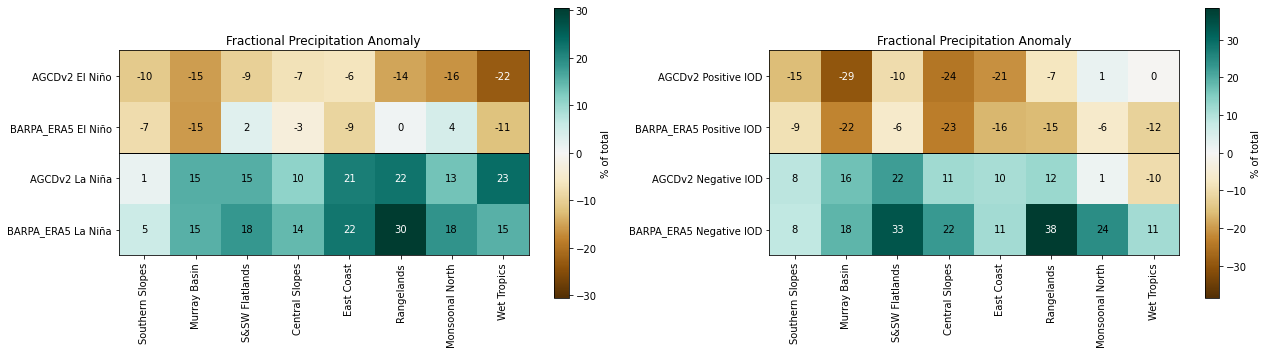

In [87]:
plt.figure(figsize=(18,5))
plt.subplot(121,aspect=1)
x=(100*pr_nino).plot.pcolormesh(cmap='BrBG',cbar_kwargs = {'label':"% of total"})
plt.xticks(range(len(labels)),labels,rotation=90)
plt.yticks(range(len(indices_nino)),indices_nino)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,100*pr_nino.values,"%d")
plt.title("Fractional Precipitation Anomaly")
plt.ylabel("")
plt.xlabel("")

plt.subplot(122,aspect=1)
x=(100*pr_iod).plot.pcolormesh(cmap='BrBG',cbar_kwargs = {'label':"% of total"})
plt.xticks(range(len(labels)),labels,rotation=90)
plt.yticks(range(len(indices_iod)),indices_iod)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,100*pr_iod.values,"%d")
plt.title("Fractional Precipitation Anomaly")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()

(4, 8) (4, 8)
(4, 8) (4, 8)


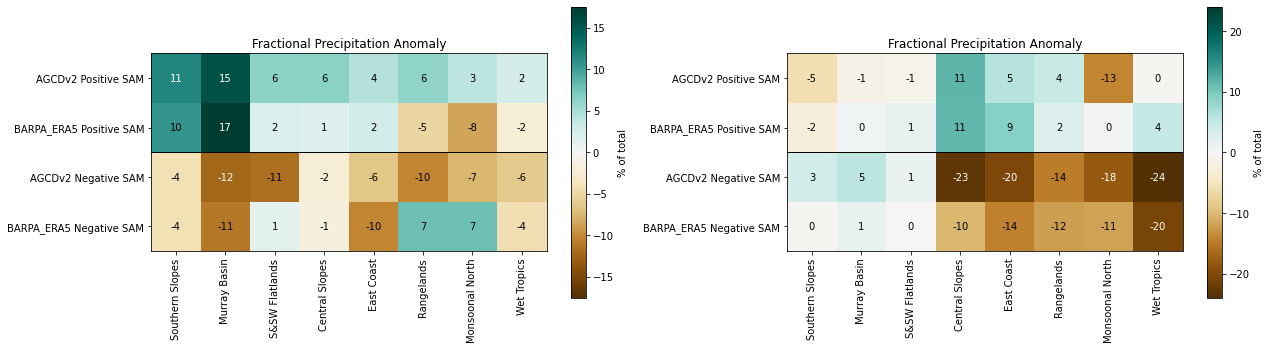

In [26]:
plt.figure(figsize=(18,5))
plt.subplot(121,aspect=1)
x=(100*pr_sam_summer).plot.pcolormesh(cmap='BrBG',cbar_kwargs = {'label':"% of total"})
plt.xticks(range(len(labels)),labels,rotation=90)
plt.yticks(range(len(indices_sam)),indices_sam)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,100*pr_sam_summer.values,"%d")
plt.title("Fractional Precipitation Anomaly")
plt.ylabel("")
plt.xlabel("")

plt.subplot(122,aspect=1)
x=(100*pr_sam_winter).plot.pcolormesh(cmap='BrBG',cbar_kwargs = {'label':"% of total"})
plt.xticks(range(len(labels)),labels,rotation=90)
plt.yticks(range(len(indices_sam)),indices_sam)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,100*pr_sam_winter.values,"%d")
plt.title("Fractional Precipitation Anomaly")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()

In [27]:
var='tasmax'
tmax= open_datasets(['BARPA_ERA5','AGCDv1'],var,1979,2008)
tmax['BARPA_ERA5']=tmax['BARPA_ERA5'].drop_vars('height')
agg_tmax = {}
for model in tmax:
    agg_tmax[model] = agg_regions(tmax[model],nrm,var,order)
    

tmax_nino,indices_nino = make_composites(agg_tmax, {"La Niña":(nino<-0.8),"El Niño":(nino>0.8)},False)
tmax_iod,indices_iod = make_composites(agg_tmax, {"Negative IOD":(dmi<-0.4),"Positive IOD":(dmi>0.4)},False)    

(4, 8) (4, 8)
(4, 8) (4, 8)


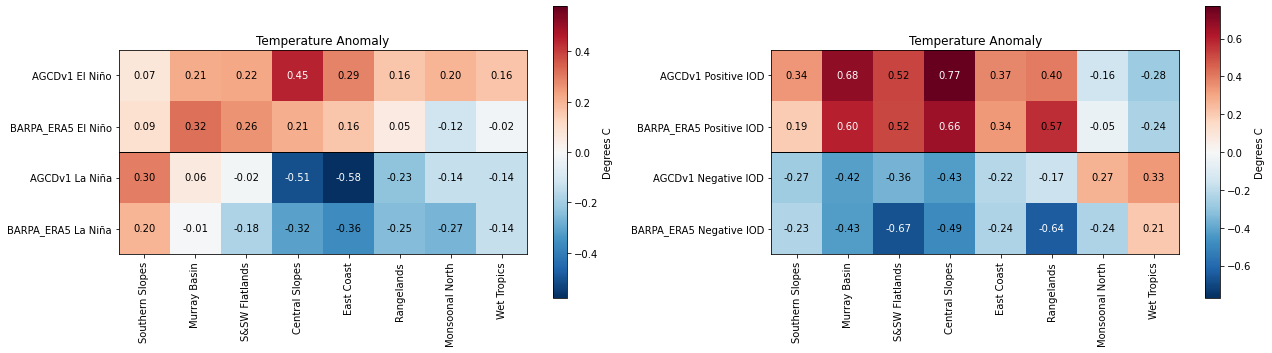

In [144]:
plt.figure(figsize=(18,5))
plt.subplot(121,aspect=1)
x=(tmax_nino).plot.pcolormesh(cbar_kwargs = {'label':'Degrees C'})
plt.xticks(range(len(labels)),labels,rotation=90)
plt.yticks(range(len(indices_nino)),indices_nino)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,tmax_nino.values,"%.2f")
plt.title("Maximum Temperature Anomaly")
plt.ylabel("")
plt.xlabel("")

plt.subplot(122,aspect=1)
x=(tmax_iod).plot.pcolormesh(cbar_kwargs = {'label':"Degrees C"})
plt.xticks(range(len(labels)),labels,rotation=90)
plt.yticks(range(len(indices_iod)),indices_iod)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,tmax_iod.values,"%.2f")
plt.title("Maximum Temperature Anomaly")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()

In [145]:
var='tasmin'
tmin= open_datasets(['BARPA_ERA5','AGCDv1'],var,1979,2008)
tmin['BARPA_ERA5']=tmin['BARPA_ERA5'].drop_vars('height')
agg_tmin = {}
for model in data:
    agg_tmin[model] = agg_regions(tmin[model],nrm,var,order)


tmin_nino,indices_nino = make_composites(agg_tmin, {"La Niña":(nino<-0.8),"El Niño":(nino>0.8)},False)
tmin_iod,indices_iod = make_composites(agg_tmin, {"Negative IOD":(dmi<-0.4),"Positive IOD":(dmi>0.4)},False)    

(4, 8) (4, 8)
(4, 8) (4, 8)


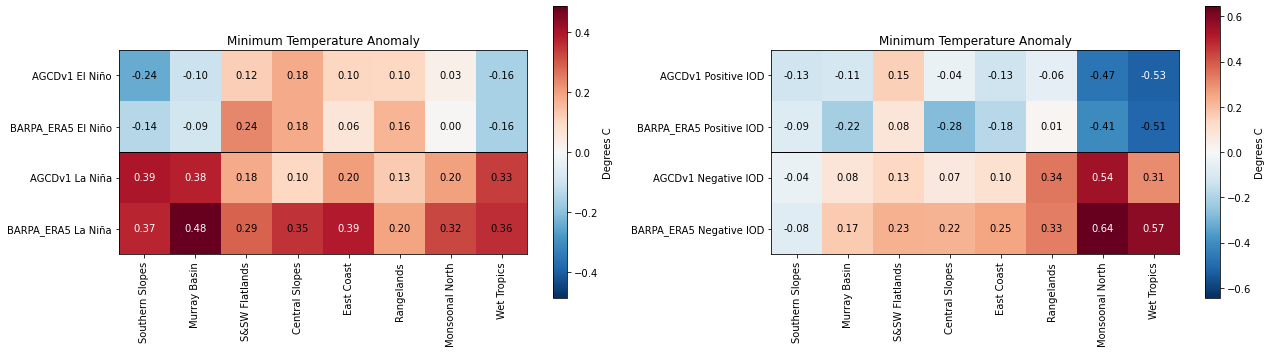

In [146]:
plt.figure(figsize=(18,5))
plt.subplot(121,aspect=1)
x=(tmin_nino).plot.pcolormesh(cbar_kwargs = {'label':'Degrees C'})
plt.xticks(range(len(labels)),labels,rotation=90)
plt.yticks(range(len(indices_nino)),indices_nino)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,tmin_nino.values,"%.2f")
plt.title("Minimum Temperature Anomaly")
plt.ylabel("")
plt.xlabel("")

plt.subplot(122,aspect=1)
x=(tmin_iod).plot.pcolormesh(cbar_kwargs = {'label':"Degrees C"})
plt.xticks(range(len(labels)),labels,rotation=90)
plt.yticks(range(len(indices_iod)),indices_iod)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,tmin_iod.values,"%.2f")
plt.title("Minimum Temperature Anomaly")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()

In [140]:
pr

{'BARPA_ERA5': <xarray.Dataset>
 Dimensions:    (time: 348, lat: 436, lon: 777, bnds: 2)
 Coordinates:
   * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2007-12-16T12:00:00
   * lat        (lat) float64 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
   * lon        (lon) float64 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
 Dimensions without coordinates: bnds
 Data variables:
     pr         (time, lat, lon) float64 dask.array<chunksize=(12, 436, 777), meta=np.ndarray>
     time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
 Attributes: (12/56)
     axiom_version:                  0.1.0
     axiom_schemas_version:          0.1.0
     axiom_schema:                   cordex-1M.json
     productive_version:             v1
     Conventions:                    CF-1.9, ACDD-1.3
     title:                          Bureau of Meteorology Atmospheric Regiona...
     ...                             ...
     frequency:                      

In [29]:
pr['BARPA_ERA5']

<xarray.Dataset>
Dimensions:    (time: 348, lat: 436, lon: 777, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2007-12-16T12:00:00
  * lat        (lat) float64 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon        (lon) float64 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float64 dask.array<chunksize=(12, 436, 777), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:                  0.1.0
    axiom_schemas_version:          0.1.0
    axiom_schema:                   cordex-1M.json
    productive_version:             v1
    Conventions:                    CF-1.9, ACDD-1.3
    title:                          Bureau of Meteorology Atmospheric Regiona...
    ...                             ...
    frequency:                      mon
    tracking_id:                    ce72dabe-3441-4530-8075-0f6c761609e5
    date_created:                   2022-08-31T07:04:45Z
    date_modified:                  2022-08-31T07:04:45Z
    date_metadata_modified:         2022-08-31T07:04:45Z
    history:                        Wed Aug 31 17:03:09 2022: /g/data/access/...

In [45]:
#agg_pr['BARPA_ERA5'] = agg_pr['BARPA_ERA5'].assign_coords(year_month=agg_pr['BARPA_ERA5'].time.dt.strftime("%Y-%m"))


<xarray.DataArray 'pr' ()>
array(65.07385054)